<a href="https://colab.research.google.com/github/Khoawawa/ArtDetective/blob/main/loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
if 'google.colab' in sys.modules:
    !git clone https://github.com/Khoawawa/ArtDetective.git

In [2]:
if 'google.colab' in sys.modules:
    !kaggle datasets download -d alessandrasala79/ai-vs-human-generated-dataset -p /content/dataset --unzip

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from IPython.display import display
import seaborn as sns

In [9]:
path = "/content/dataset" if "google.colab" in sys.modules else "E:/Code/Python/ML/dataset/HumanvsAi"
TRAIN_CSV = path + '/train.csv'
TEST_CSV = path + '/test.csv'
DATA_DIR = path

In [12]:
train_df = pd.read_csv(TRAIN_CSV)
train_df = train_df[['file_name','label']]
train_df.columns = ['id','label']
train_df.head()

,id,label
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [13]:
test_df = pd.read_csv(TEST_CSV)
test_df.head()

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [14]:
print('Train set: ', len(train_df))
print('Test set: ', len(test_df))

Train set:  79950
Test set:  5540


Check for completeness

In [15]:
print("Train null counts: ")
print(train_df.isnull().sum())
print("Test null counts: ")
print(test_df.isnull().sum())

Train null counts: 
id       0
label    0
dtype: int64
Test null counts: 
id    0
dtype: int64


Check for file existence

In [16]:
def check_file_existence(df):
  missing = []
  for fname in df['id']:
    if not os.path.isfile(os.path.join(DATA_DIR, fname)):
      missing.append(fname)
  return missing
train_missing = check_file_existence(train_df)
test_missing = check_file_existence(test_df)

print(f'Missing train: {len(train_missing)}/{len(train_df)}')
print(f'Missing test: {len(test_missing)}/{len(test_df)}')

Missing train: 0/79950
Missing test: 0/5540


MERGING FULL_FILE PATH

In [17]:
train_df['id'] = train_df['id'].apply(lambda x: os.path.join(DATA_DIR, x))
test_df['id'] = test_df['id'].apply(lambda x: os.path.join(DATA_DIR, x))

In [18]:
train_df['pair_id'] = train_df.index //2
train_df.head()

,id,label,pair_id
0,E:/Code/Python/ML/dataset/HumanvsAi\train_data...,1,0
1,E:/Code/Python/ML/dataset/HumanvsAi\train_data...,0,0
2,E:/Code/Python/ML/dataset/HumanvsAi\train_data...,1,1
3,E:/Code/Python/ML/dataset/HumanvsAi\train_data...,0,1
4,E:/Code/Python/ML/dataset/HumanvsAi\train_data...,1,2


Removing duplicate


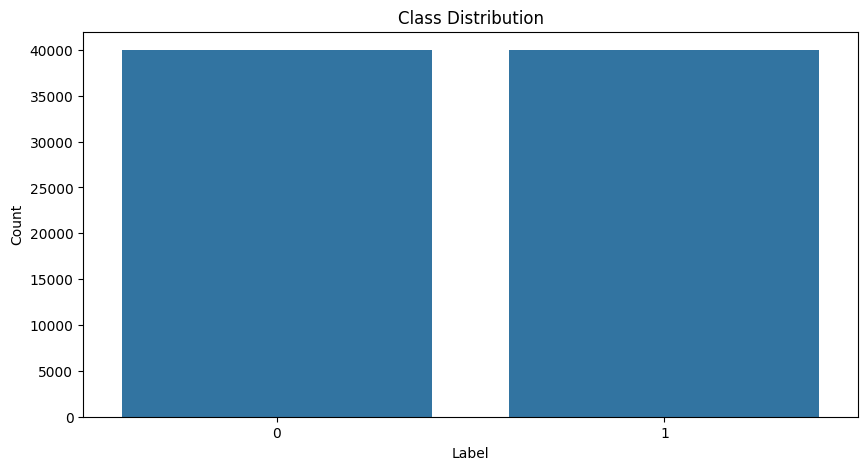

In [19]:
# Class balance
label_counts = train_df["label"].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [20]:
pair_violations = sum(train_df['label'].diff()[1::2]!= -1) # think of it as if there are 2 of the same labels next to each other it would be 0
print(f'Pairing violations: {pair_violations}/{len(train_df)//2}')

Pairing violations: 0/39975


In [21]:
# Pair completeness check
pair_sizes = train_df.groupby("pair_id")["id"].count().value_counts()
print("\nPair size distribution:")
print(pair_sizes)


Pair size distribution:
id
2    39975
Name: count, dtype: int64


--> K fold cross validation and Binary Cross-Entropy

=== Image Metadata Analysis ===


Processing images: 100%|██████████| 79950/79950 [14:02<00:00, 94.87it/s] 



=== Dimension Statistics ===
Average dimensions: 716.6x569.6
Dimension distribution:
              width        height
count  79950.000000  79950.000000
mean     716.566654    569.553171
std      101.020008    118.955900
min      320.000000    112.000000
25%      768.000000    512.000000
50%      768.000000    512.000000
75%      768.000000    640.000000
max      768.000000    768.000000


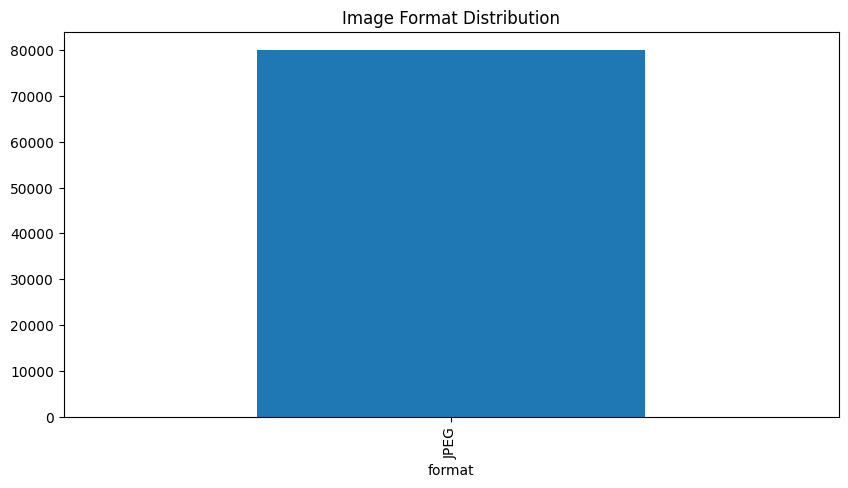


Channel distribution:
channels
3    79774
1      176
Name: count, dtype: int64


In [22]:
def analyze_image_metadata(train_df, sample_size=10000):
    print("=== Image Metadata Analysis ===")

    # Sampling
    sample = train_df.sample(sample_size, random_state=42)
    metadata = []

    for _, row in tqdm(sample.iterrows(), total=sample_size, desc="Processing images"):
        img_path = row['id']
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                mode = img.mode
                format_ = img.format
        except:
            width, height, mode, format_ = (None,)*4

        metadata.append({
            "width": width,
            "height": height,
            "channels": len(mode) if mode else None,
            "format": format_
        })

    meta_df = pd.DataFrame(metadata)

    # Dimension analysis
    print("\n=== Dimension Statistics ===")
    print(f"Average dimensions: {meta_df['width'].mean():.1f}x{meta_df['height'].mean():.1f}")
    print("Dimension distribution:")
    print(meta_df[['width', 'height']].describe())

    # Format distribution
    plt.figure(figsize=(10, 5))
    meta_df['format'].value_counts().plot(kind='bar')
    plt.title("Image Format Distribution")
    plt.show()

    # Channel analysis
    channel_dist = meta_df['channels'].value_counts()
    print("\nChannel distribution:")
    print(channel_dist)

    return meta_df

meta_df = analyze_image_metadata(train_df,len(train_df))

=== Visual Pattern Analysis ===


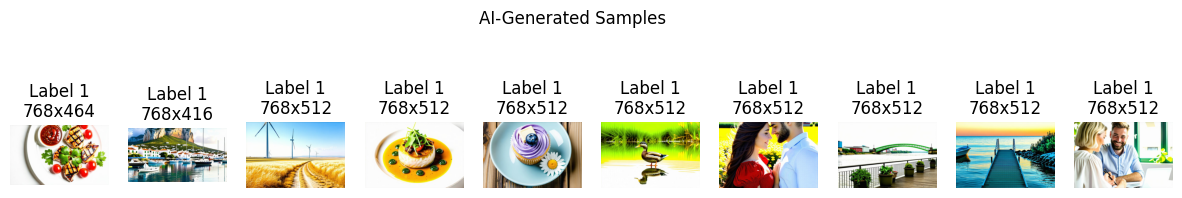

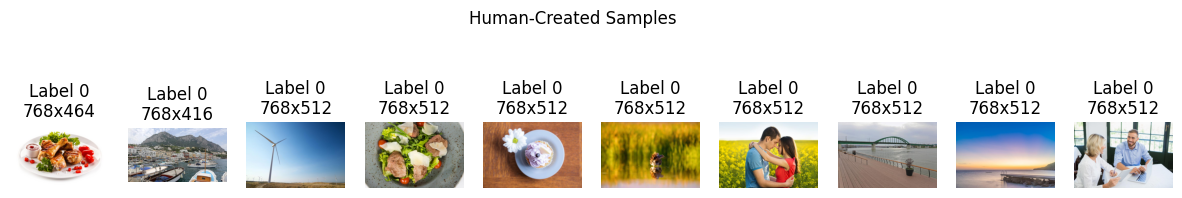

In [23]:
def visualize_image_samples(train_df, n_samples=5):
    print("=== Visual Pattern Analysis ===")

    def plot_comparison(label, title):
        plt.figure(figsize=(15, 3))
        samples = train_df[train_df['label'] == label].sample(n_samples, random_state=42)
        for i, (_, row) in enumerate(samples.iterrows()):
            img_path = row['id']
            try:
                img = Image.open(img_path)
                plt.subplot(1, n_samples, i+1)
                plt.imshow(img)
                plt.title(f"Label {label}\n{img.size[0]}x{img.size[1]}")
                plt.axis('off')
            except:
                plt.title("Failed to load")
        plt.suptitle(title)
        plt.show()

    # Compare AI vs Human
    plot_comparison(1, "AI-Generated Samples")
    plot_comparison(0, "Human-Created Samples")

visualize_image_samples(train_df,10)

In [24]:
def visualize_gray_scale_image_samples(train_df, n_samples=5):
    print("=== Visual Pattern Analysis ===")

    def load_and_convert_to_gray(img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        return img

    def plot_comparison(label, title):
        plt.figure(figsize=(15, 3))
        samples = train_df[train_df['label'] == label].sample(n_samples, random_state=42)
        for i, (_, row) in enumerate(samples.iterrows()):
            img_path = row['id']
            try:
                img = load_and_convert_to_gray(img_path)
                plt.subplot(1, n_samples, i + 1)
                plt.imshow(img, cmap='gray')  # Ensure grayscale display
                plt.title(f"Label {label}\n{img.shape[1]}x{img.shape[0]}")
                plt.axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                plt.title("Failed to load")
        plt.suptitle(title)
        plt.show()

    # Compare AI vs Human
    plot_comparison(1, "AI-Generated Samples")
    plot_comparison(0, "Human-Created Samples")

# visualize_gray_scale_image_samples(train_df, 10)

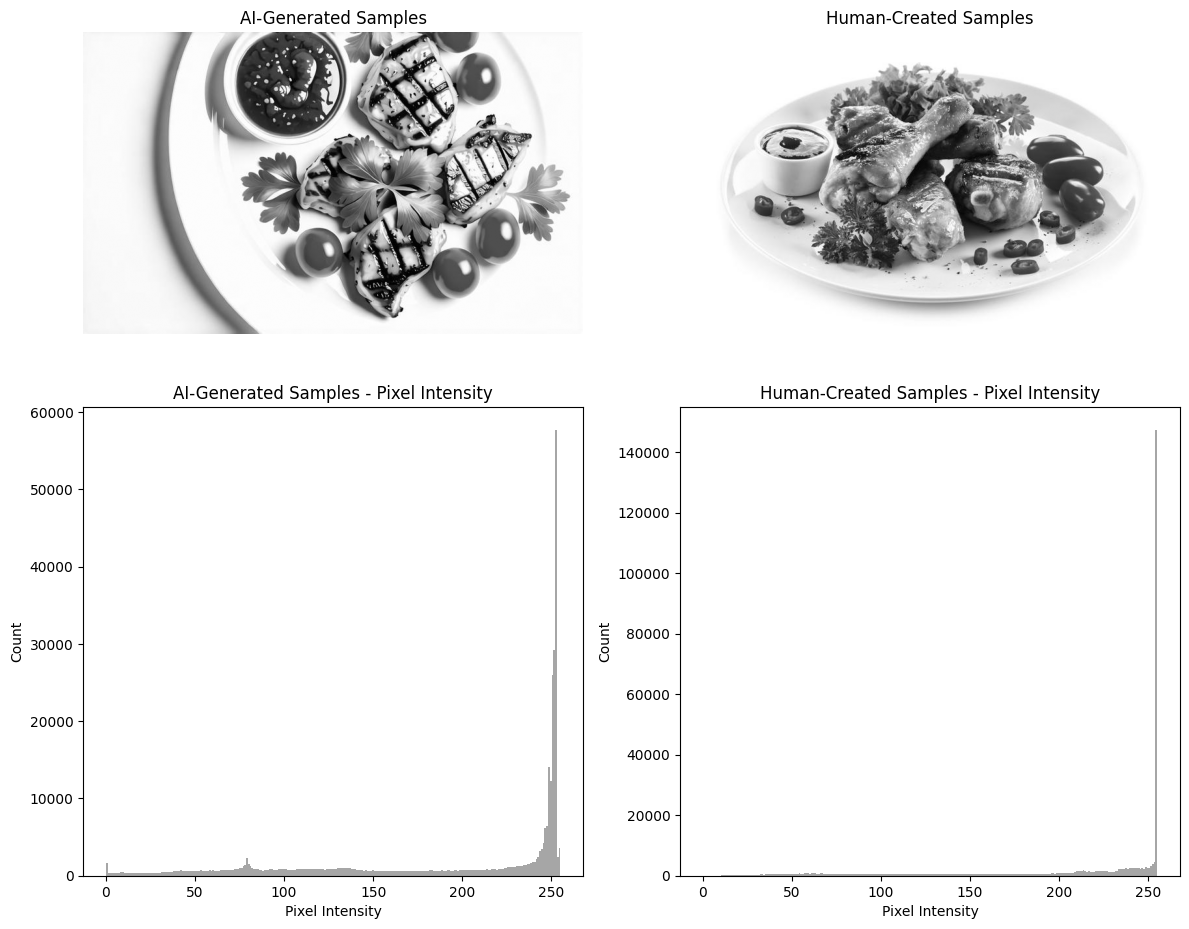

In [25]:
def plot_pixel_intensity_side_by_side(img1_path,img2_path,title1 = "AI-Generated Samples", title2 = "Human-Created Samples"):
  img1 = cv2.imread(img1_path,cv2.IMREAD_GRAYSCALE)
  img2 = cv2.imread(img2_path,cv2.IMREAD_GRAYSCALE)

  fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 1 row, 2 columns
  # Display Images
  axes[0, 0].imshow(img1, cmap='gray')
  axes[0, 0].set_title(title1)
  axes[0, 0].axis('off')

  axes[0, 1].imshow(img2, cmap='gray')
  axes[0, 1].set_title(title2)
  axes[0, 1].axis('off')

  axes[1,0].hist(img1.ravel(), bins=256, color="gray", alpha=0.7)
  axes[1,0].set_xlabel("Pixel Intensity")
  axes[1,0].set_ylabel("Count")
  axes[1,0].set_title(f"{title1} - Pixel Intensity")

  axes[1,1].hist(img2.ravel(), bins=256, color="gray", alpha=0.7)
  axes[1,1].set_xlabel("Pixel Intensity")
  axes[1,1].set_ylabel("Count")
  axes[1,1].set_title(f"{title2} - Pixel Intensity")

  plt.tight_layout()
  plt.show()

sample_ai = train_df[train_df['label'] == 1]['id'].sample(1, random_state=42).values[0]
sample_human = train_df[train_df['label'] == 0]['id'].sample(1, random_state=42).values[0]

plot_pixel_intensity_side_by_side(sample_ai,sample_human)


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
import torchvision.models as models

In [27]:
IMG_SIZE = (244,244)

In [28]:
train_transform = T.Compose([
    T.Resize(IMG_SIZE, interpolation=InterpolationMode.BICUBIC),
    T.RandomResizedCrop(IMG_SIZE),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(20),
    T.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [29]:
test_transforms = T.Compose([
    T.Resize(IMG_SIZE, interpolation=InterpolationMode.BICUBIC),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
from LBP import LBP_XG_Model
from Processor import Preprocessor
from sklearn.model_selection import train_test_split

In [32]:
print(test_df.head())

                                                  id
0  E:/Code/Python/ML/dataset/HumanvsAi\test_data_...
1  E:/Code/Python/ML/dataset/HumanvsAi\test_data_...
2  E:/Code/Python/ML/dataset/HumanvsAi\test_data_...
3  E:/Code/Python/ML/dataset/HumanvsAi\test_data_...
4  E:/Code/Python/ML/dataset/HumanvsAi\test_data_...


In [33]:
X = train_df['id']
y = train_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
transform = Preprocessor()
model = LBP_XG_Model(transform)
model.fit(X_train, y_train)

In [ ]:
print(model.predict(X_test[0]) != y_test[0])